In [23]:
import pandas as pd
import numpy as np
import matplotlib as pt
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 20, 8
import plotly.graph_objs as go
import chart_studio.plotly
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from pandas import DataFrame

In [2]:
df_Vadhvan=pd.read_csv("Vadhvan.csv")

In [3]:
required_data = df_Vadhvan[['Modal_Price','Arrival_Date','Tons']]
required_data.index = required_data['Arrival_Date']
required_data.index=pd.DatetimeIndex(required_data.index)
required_data=required_data.drop("Arrival_Date",axis=1)
required_data['Modal_Price'] = required_data['Modal_Price'].map(lambda x: float(x))
required_data = required_data.fillna(required_data.bfill())
prices=required_data['Modal_Price']
idx = pd.period_range(start=min(df_Vadhvan.Arrival_Date), end=max(df_Vadhvan.Arrival_Date),freq="D")
required_data.index=required_data.index.to_period("D")
#filling missing days
required_data=required_data.reindex(idx, method='ffill')

In [4]:
df_log = np.log(required_data)

In [5]:
train_data, test_data = df_log[3:int(len(df_log)*0.95)],df_log[int(len(df_log)*0.95):]

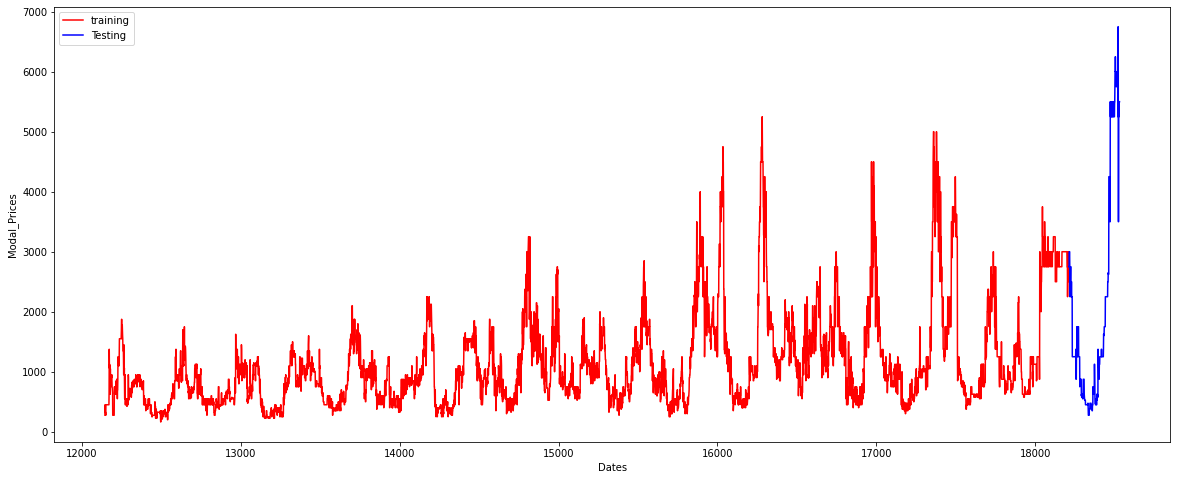

In [6]:
plt.plot(train_data.index,np.exp(train_data.Modal_Price), label='training',color='red')
plt.plot(test_data.index,np.exp(test_data.Modal_Price), color = 'blue', label='Testing')
plt.xlabel('Dates')
plt.ylabel('Modal_Prices')
plt.legend()
plt.show()

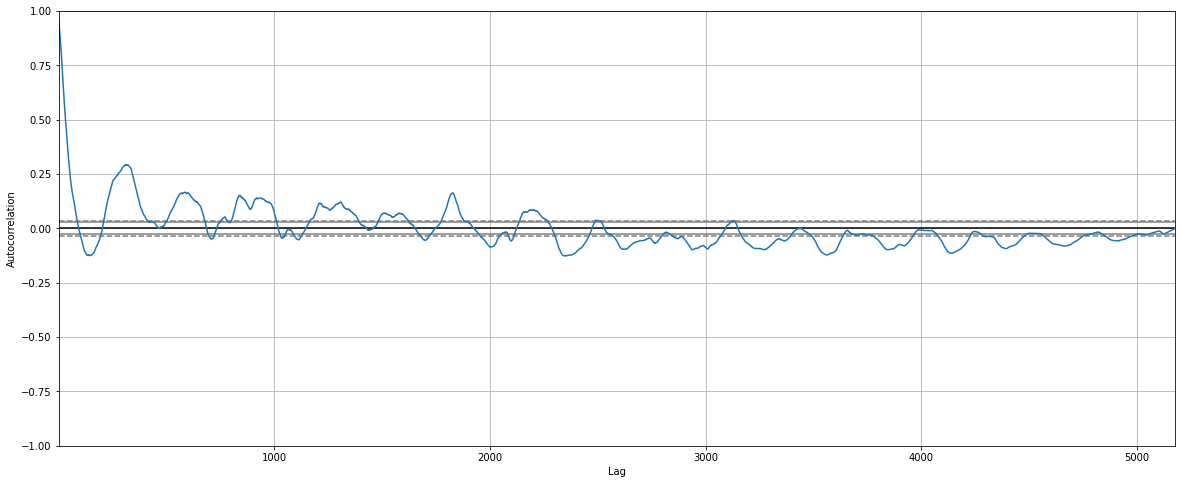

In [7]:
autocorrelation_plot(prices)
plt.show()

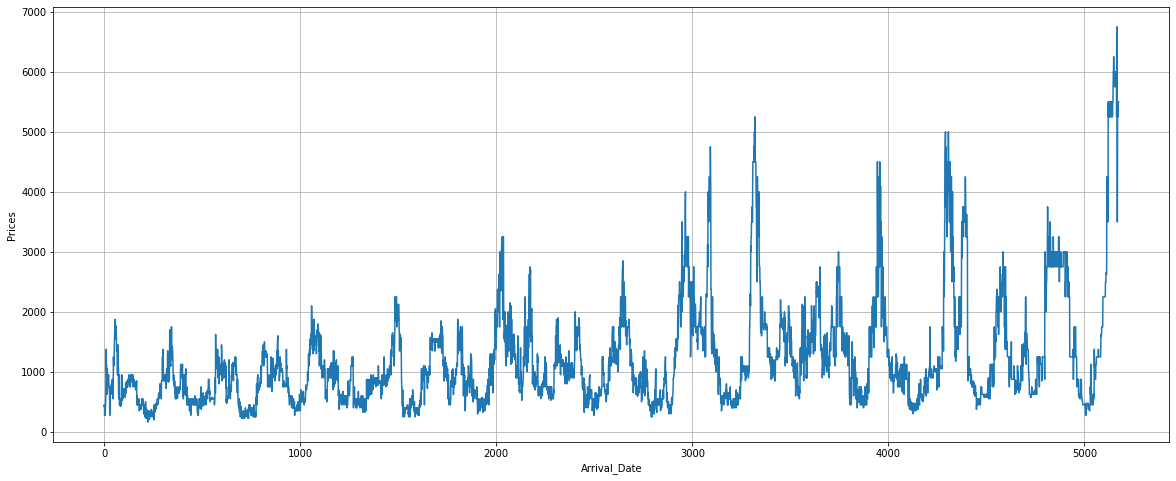

In [8]:
plt.grid(True)
plt.xlabel('Arrival_Date')
plt.ylabel("Prices")
plt.plot(df_Vadhvan['Modal_Price'])

Text(0, 0.5, 'Prices')

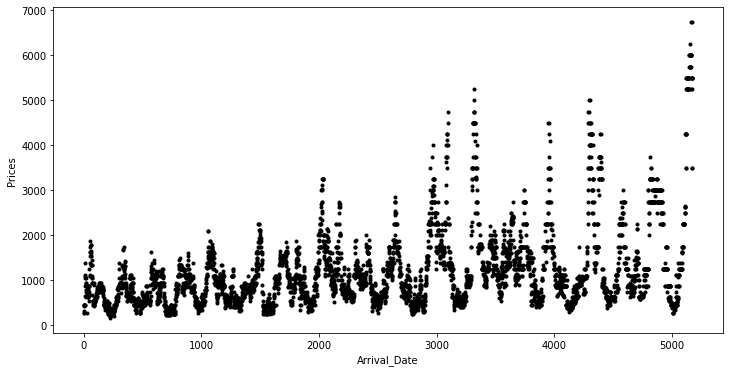

In [9]:
df_close = df_Vadhvan['Modal_Price']
df_close.plot(style='k.',figsize=(12,6))
plt.xlabel('Arrival_Date')
plt.ylabel("Prices")

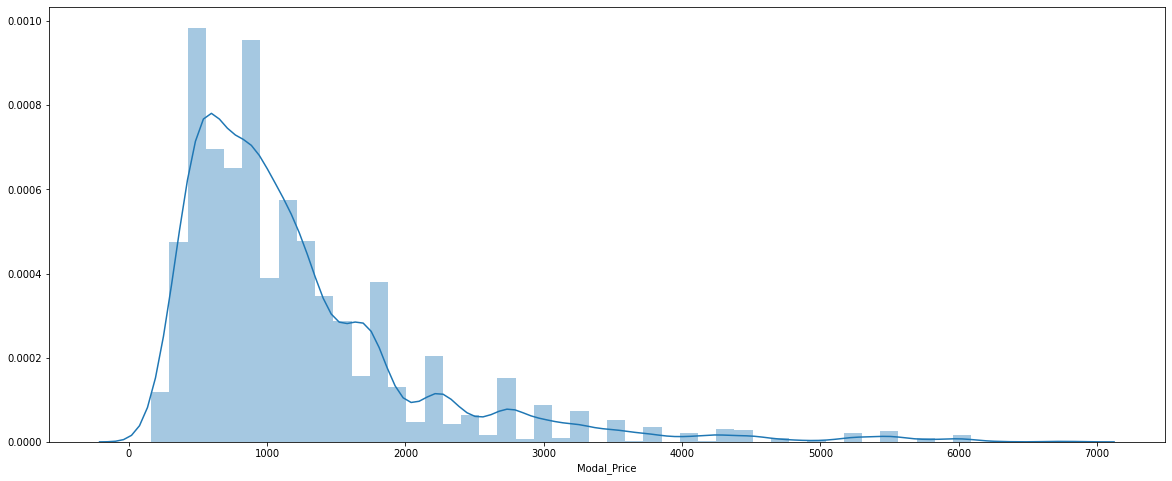

In [10]:
sns.distplot(df_Vadhvan['Modal_Price'])

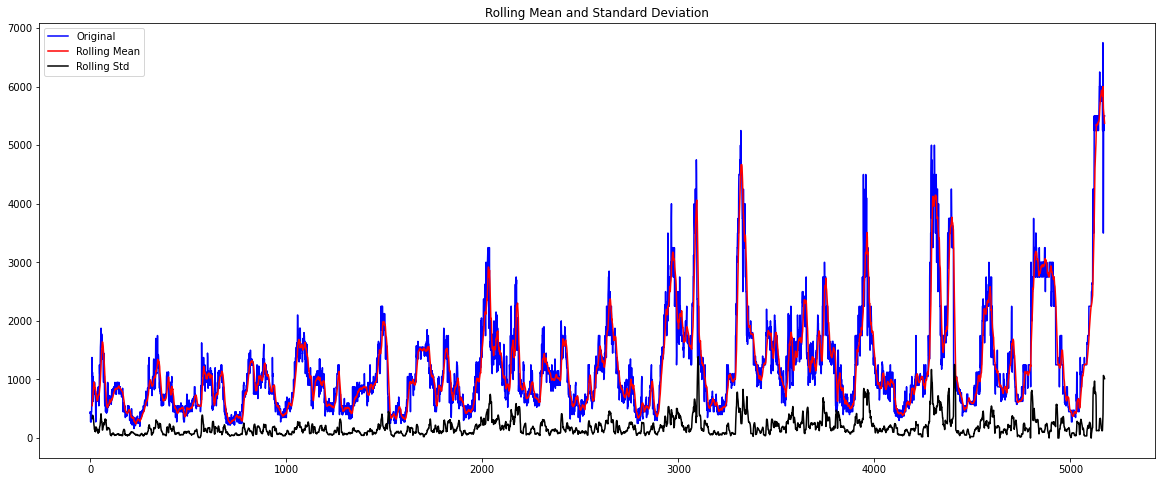

Results of dickey fuller test
Test Statistics                  -5.507179
p-value                           0.000002
No. of lags used                 23.000000
Number of observations used    5151.000000
critical value (1%)              -3.431620
critical value (5%)              -2.862101
critical value (10%)             -2.567069
dtype: float64


In [11]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_Vadhvan['Modal_Price'])

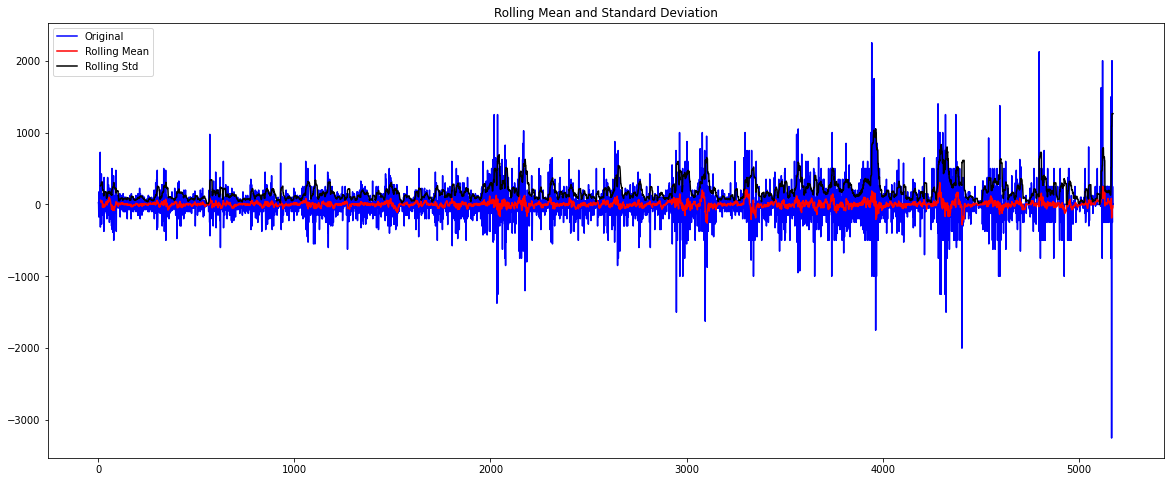

Results of dickey fuller test
Test Statistics               -1.425720e+01
p-value                        1.447140e-26
No. of lags used               2.800000e+01
Number of observations used    5.145000e+03
critical value (1%)           -3.431622e+00
critical value (5%)           -2.862102e+00
critical value (10%)          -2.567069e+00
dtype: float64


In [12]:
first_diff = df_Vadhvan.Modal_Price - df_Vadhvan.Modal_Price.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff)

In [38]:
result=seasonal_decompose(df_Vadhvan.Modal_Price,model='multiplicative',freq=365)

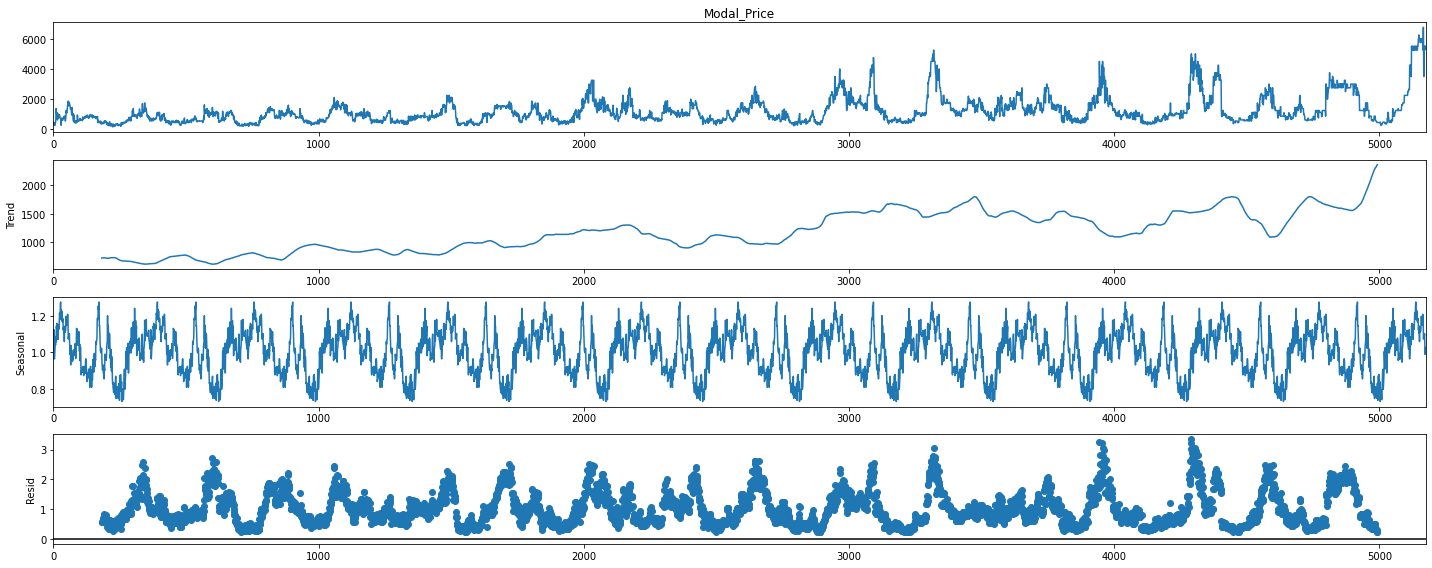

<Figure size 1440x576 with 0 Axes>

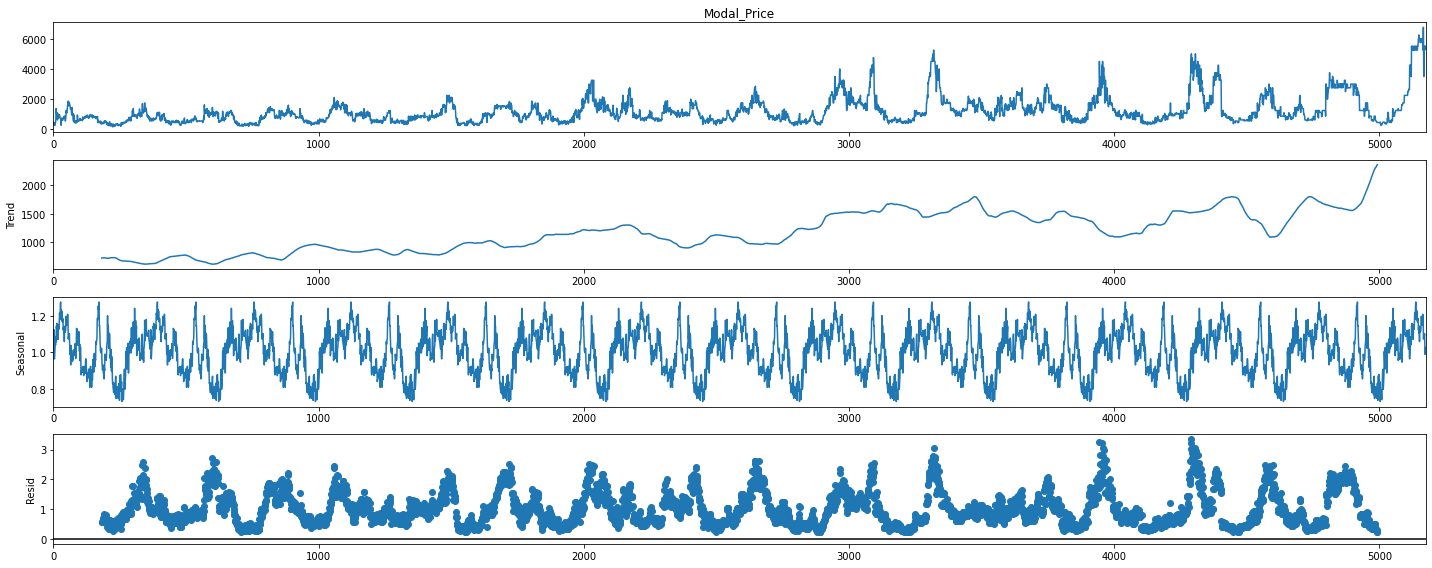

In [41]:
plt.figure()  
result.plot()  

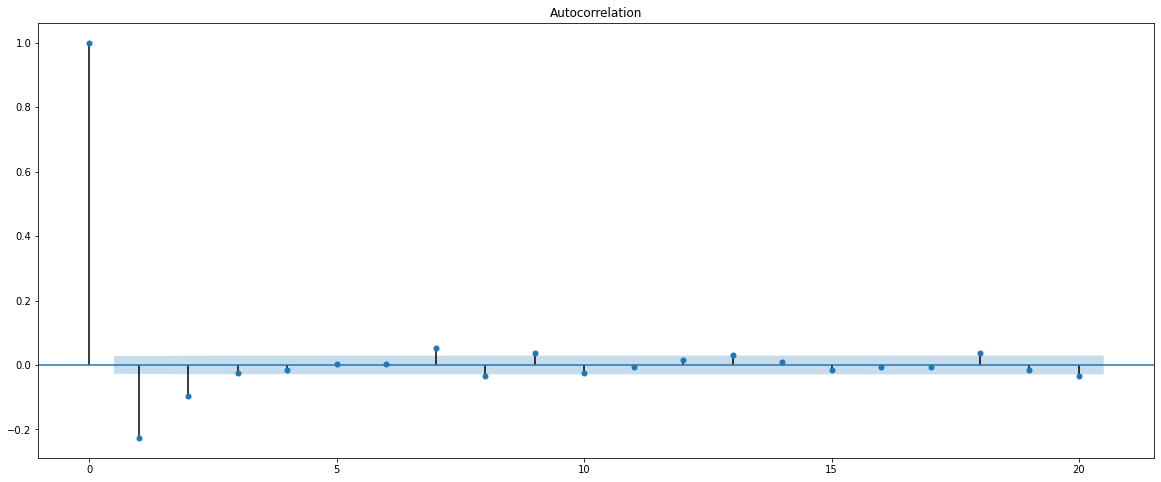

In [15]:
plot_acf(first_diff, lags=20);

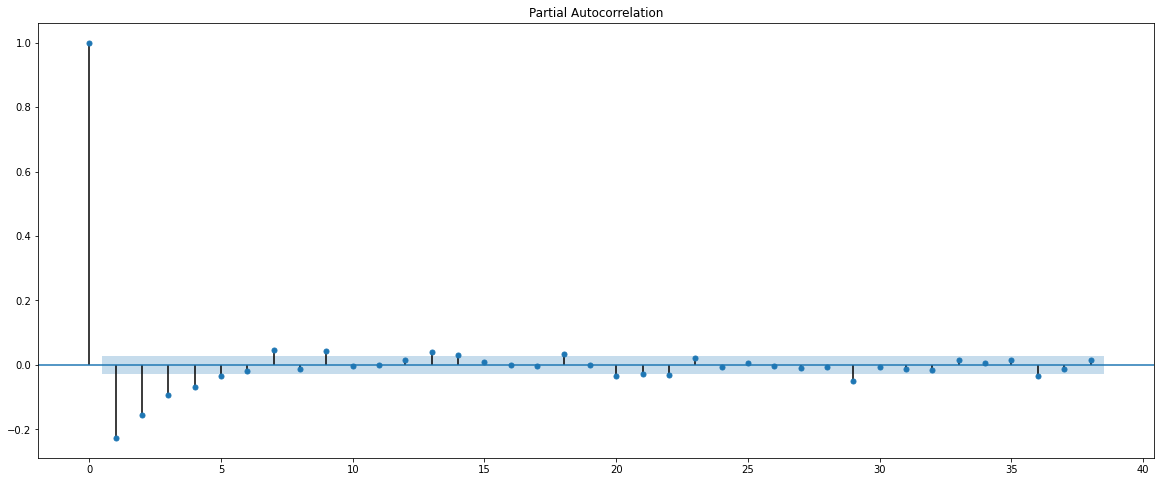

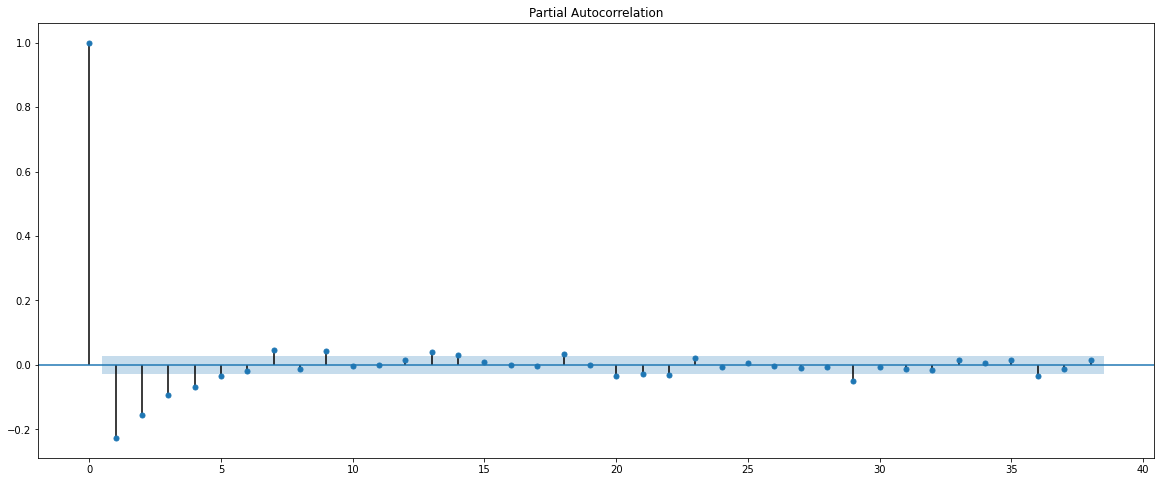

In [16]:
plot_pacf(first_diff)

In [17]:
#modal building

In [19]:
mod = sm.tsa.arima.ARIMA(train_data.Modal_Price, order=(1, 1, 1), seasonal_order=(1, 1, 0, 365))
res = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')

In [20]:
forecast=res.forecast(steps=test_data.shape[0])

In [24]:
Forecast = DataFrame(forecast,columns=['Forecast'])

In [25]:
Forecast = pd.DataFrame(forecast)
Forecast.rename(columns = {0:'Forecast'}, inplace = True) 
Forecast.reset_index(drop=True)
idx1=pd.period_range(start=min(test_data.index), end=max(test_data.index),freq="D")
Forecast=Forecast.reindex(idx1, method='ffill')
Forecast

,Forecast
2019-11-12,7.939173
2019-11-13,7.947466
2019-11-14,7.817035
2019-11-15,7.745098
2019-11-16,7.921905
...,...
2020-09-22,7.846625
2020-09-23,7.846625
2020-09-24,7.846625
2020-09-25,7.846625


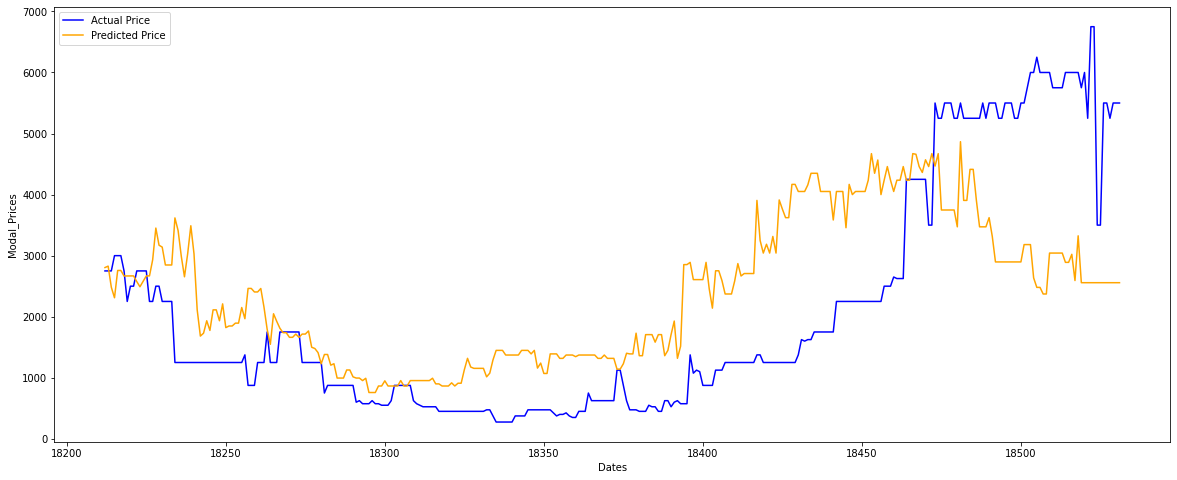

In [26]:
plt.plot(test_data.index,np.exp(test_data.Modal_Price), color = 'blue', label='Actual Price')
plt.plot(Forecast.index,np.exp(Forecast.Forecast), color = 'orange',label='Predicted Price')
plt.xlabel('Dates')
plt.ylabel('Modal_Prices')
plt.legend()
plt.show()

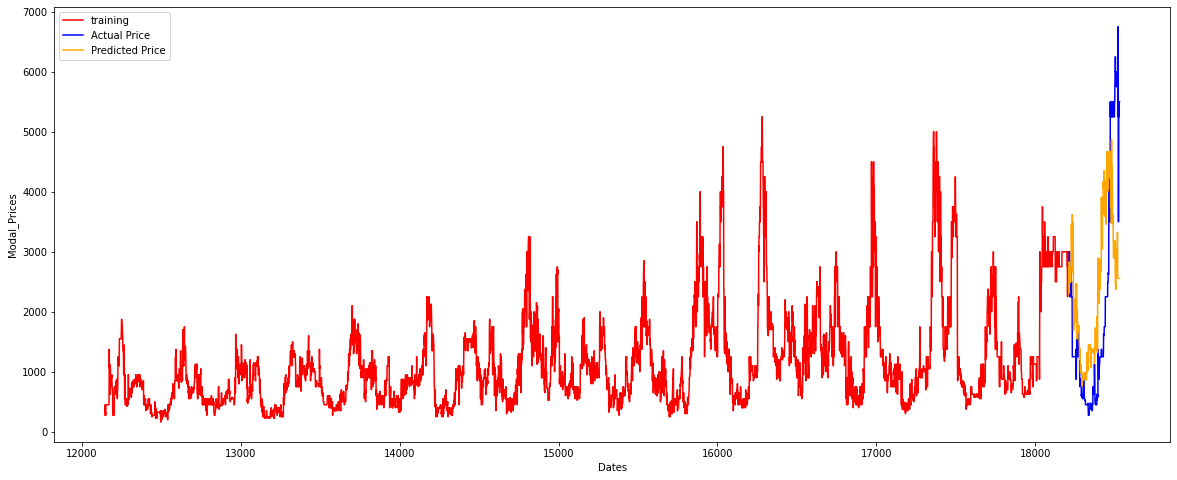

In [27]:
plt.plot(train_data.index,np.exp(train_data.Modal_Price), label='training',color='red')
plt.plot(test_data.index,np.exp(test_data.Modal_Price), color = 'blue', label='Actual Price')
plt.plot(Forecast.index,np.exp(Forecast.Forecast), color = 'orange',label='Predicted Price')
plt.xlabel('Dates')
plt.ylabel('Modal_Prices')
plt.legend()
plt.show()

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return( np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
MAPE=mean_absolute_percentage_error(test_data.Modal_Price,Forecast.Forecast)
accuracy=100-MAPE
print("Accuracy :" ,accuracy)
print("Mean Average Percentage Error:",MAPE)

Accuracy : 90.57312116354004
Mean Average Percentage Error: 9.42687883645996


In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_data.Modal_Price,Forecast.Forecast))
print("RMSE :",rmse)

RMSE : 0.7540369577845538


In [32]:
mod1 = sm.tsa.arima.ARIMA(df_log.Modal_Price, order=(1, 1, 1), seasonal_order=(1, 1, 0, 365))
res1 = mod1.fit(method='innovations_mle', low_memory=True, cov_type='none')

In [35]:
forecast1=res1.forecast(steps=30)

In [36]:
Forecast1 = DataFrame(forecast1,columns=['Forecast'])
Forecast1.rename(columns = {0:'Forecast'}, inplace = True) 
Forecast1.reset_index(drop=True)

,Forecast
0,8.711858
1,8.595420
2,8.677877
3,8.676910
4,8.676492
5,8.636321
6,8.636243
7,8.636209
8,8.472579
9,8.472572


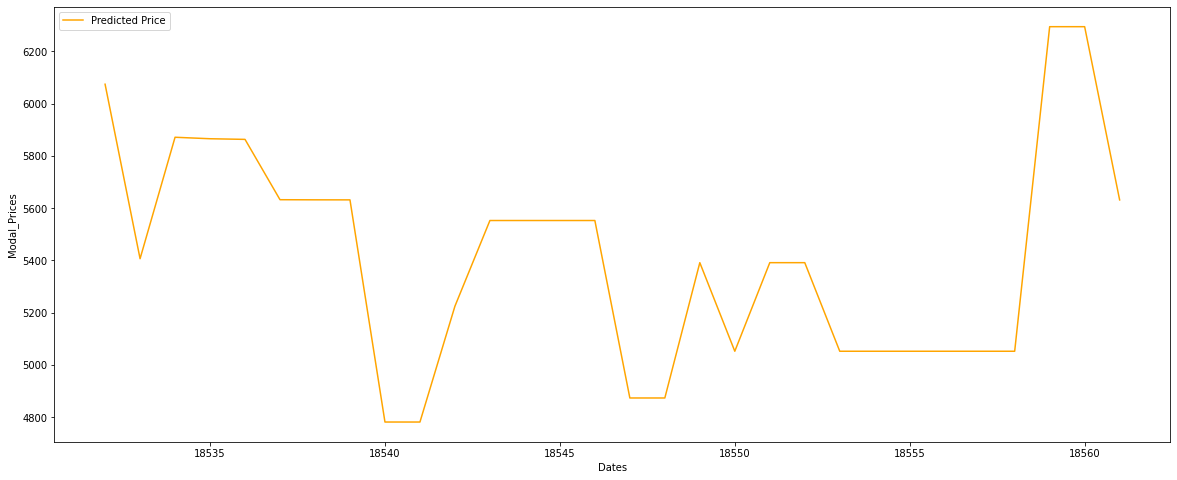

In [37]:
plt.plot(Forecast1.index,np.exp(Forecast1.Forecast), color = 'orange',label='Predicted Price')
plt.xlabel('Dates')
plt.ylabel('Modal_Prices')
plt.legend()
plt.show()